# PRICES ANALYSIS
Workflow:
* Inspect dataset
* Mutate missing data.
* Verify the normalisational possibility. 
* Brainstormed questions.
* Build Machine Learning model to answer the possible question(s).
* Evaluate the model. 
* Conclusion: what question(s) can be answered. 


Questions for this dataset: 
- Is there any connection among the fields? 
- Can we predict the sales of the market with our data?
- Is conventional or organic are being preferred in the market? 
- Assume there are available data in the data lake, but the fields vary:
- - What are the most general fields that also exists in our dataset? 
- - Can the ML model that built based on those fields generate a good prediction? 
- - Can we also forecast the sales regionally?

Technical Outcome:
- Missing values mutated by the mean based on the respective region and type. 
- Data are not normalised.
- General fields picked are: "AveragePrice", "TotalVolume", "TotalBags", "SmallBags", "LargeBags", "XLargeBags"
- Decision Tree model can forecast the "type" field with accuracy around 96%.
- A quite linear relationship between "SmallBags" and "TotalBags" and "LargeBags" and "TotalBags". 
- The regional prediction is not suggested due to low accuracy. 

### Data Cleansing

In [1]:
import pandas as pd # for csv handling
import seaborn # for pair plotting 
import matplotlib.pyplot as plt # for visualisation
from sklearn import preprocessing

Next:
* load the CSV file and store under df variable
* check the types of each colum (field)
* check null value
* if null value, replace it with value = "nan" 
* check number of rows that contain null value


In [2]:
# load csv file and inspect the data types of each column
df = pd.read_csv("prices.csv")
df.dtypes

Date             object
AveragePrice    float64
TotalVolume     float64
4046            float64
4225            float64
4770            float64
TotalBags       float64
SmallBags       float64
LargeBags       float64
XLargeBags      float64
type             object
year              int64
region           object
dtype: object

In [3]:
# inspect the first 5 rows of the dataset
df.head(5)

,Date,AveragePrice,TotalVolume,4046,4225,4770,TotalBags,SmallBags,LargeBags,XLargeBags,type,year,region
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
1,2015-01-04,1.00,435021.49,364302.39,23821.16,82.15,46815.79,16707.15,30108.64,0.0,conventional,2015,Atlanta
2,2015-01-04,NaN,788025.06,53987.31,552906.04,39995.03,141136.68,137146.07,3990.61,0.0,conventional,2015,BaltimoreWashington
3,2015-01-04,1.01,80034.32,44562.12,24964.23,2752.35,7755.62,6064.30,1691.32,0.0,conventional,2015,Boise
4,2015-01-04,1.02,491738.00,7193.87,396752.18,128.82,87663.13,87406.84,256.29,0.0,conventional,2015,Boston


In [4]:
# replace null value with "nan"
df = df.fillna("nan")

In [5]:
# count the number of rows that have "nan" value
# display under the DataFrame-styled

def count_null_rows(df):
    '''
    Count the rows that have "nan" value
    Input: df (data frame)
    '''
    invalid = 0
    for i in range(len(df)):
        for j in df.iloc[i]:
            if j == "nan":
                invalid += 1
                break
    return invalid

null_rows = count_null_rows(df)
pd.DataFrame({"Total rows": [len(df)],
             "Rows have null": null_rows,
            "Missing percent": [null_rows/len(df)*100]})

,Total rows,Rows have null,Missing percent
0,25161,6760,26.866977


In [6]:
# Futher check which column has null values
print("Null values in column(s): \n")
for column in df.columns:
    if len(df[df[column] == "nan"][column]) != 0:
        print(column)  

Null values in column(s): 

AveragePrice
TotalVolume
4046
4225
4770
TotalBags
SmallBags
LargeBags
XLargeBags


Around 26.87%, more than 1/4 of the total rows that have null value. Each column also have null value. Replace these with 0 or remove them from the dataset can be risky and affect the outcomes later. 
* Risky when replacing with 0 is because, Total Volume should not be 0 given the actual values are at least tens of thousands. 
* If remove them completely, the dataset can be too small when training the machine. 

There are 02 lexical data, which are the classification variables. Let us examine them to see if there exists a difference in value among themselves. 

In [7]:
# Check the distinct values in the lexical fields with this function
def distinct_lexicalData(df):
    '''
    Check the distinct of lexical data in the dataset
    '''
    for column in ["type", "region"]:
        print(f"{column} => {set(df[column])} => length = {len(set(df[column]))}\n")
distinct_lexicalData(df)

type => {'conventional', 'organic'} => length = 2

region => {'RichmondNorfolk', 'DallasFtWorth', 'Syracuse', 'Roanoke', 'Orlando', 'Plains', 'Chicago', 'Charlotte', 'SanDiego', 'Northeast', 'Nashville', 'SouthCarolina', 'West', 'Detroit', 'MiamiFtLauderdale', 'Philadelphia', 'Columbus', 'Albany', 'Houston', 'Pittsburgh', 'Sacramento', 'Jacksonville', 'SouthCentral', 'NewOrleansMobile', 'California', 'TotalUS', 'LasVegas', 'BaltimoreWashington', 'GrandRapids', 'Louisville', 'PhoenixTucson', 'BuffaloRochester', 'WestTexNewMexico', 'SanFrancisco', 'Boston', 'Indianapolis', 'NewYork', 'Seattle', 'Atlanta', 'NorthernNewEngland', 'Midsouth', 'CincinnatiDayton', 'StLouis', 'GreatLakes', 'HarrisburgScranton', 'Portland', 'RaleighGreensboro', 'Denver', 'Southeast', 'Spokane', 'HartfordSpringfield', 'LosAngeles', 'Tampa', 'Boise'} => length = 54



2 types and 54 regions. This results in:
* each type has different statistics (1)
* each region has different statsitics (2)


Hypothesis:
* Should (1) is correct, so is (2).

Let's verify this:

In [8]:
# When indexing a df, numbered-values will become object-type.
# This to revert them back to its original number-type.

def revert_dtype(df):
    '''
    Revert the types of columns in the df back to the original
    '''
    for column in df.columns:
        try:
            df[column] = df[column].astype(float)
        except:
            pass
    return df

In [9]:
# check the stats of conventional type
conventional_df = revert_dtype(df[df["type"] == "conventional"])
conventional_df.describe()

<ipython-input-8-5f667780feaa>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].astype(float)


,AveragePrice,TotalVolume,4046,4225,4770,TotalBags,SmallBags,LargeBags,XLargeBags,year
count,12139.000000,1.211200e+04,1.212200e+04,1.214400e+04,1.209800e+04,1.212100e+04,1.209600e+04,1.209500e+04,12148.000000,12582.000000
mean,1.159434,1.777011e+06,5.892787e+05,5.758027e+05,4.477848e+04,5.575701e+05,4.006423e+05,1.436442e+05,8808.141043,2016.776824
std,0.253571,5.131672e+06,1.775783e+06,1.662140e+06,1.447704e+05,1.701447e+06,1.198281e+06,4.974572e+05,35959.265201,1.323974
min,0.460000,3.369968e+04,7.206000e+01,1.518000e+03,1.000000e+00,3.047170e+03,1.119180e+03,0.000000e+00,0.000000,2015.000000
25%,0.990000,2.151556e+05,3.771386e+04,4.833402e+04,7.227000e+02,6.482245e+04,4.741415e+04,4.314095e+03,0.000000,2016.000000
50%,1.140000,4.476824e+05,1.081418e+05,1.358707e+05,5.891615e+03,1.225242e+05,8.845532e+04,2.340983e+04,309.350000,2017.000000
75%,1.310000,1.084675e+06,3.757875e+05,4.145378e+05,2.156681e+04,3.481808e+05,2.337430e+05,8.188340e+04,3240.000000,2018.000000
max,2.220000,6.371614e+07,2.274362e+07,2.047057e+07,2.546439e+06,2.347299e+07,1.543625e+07,7.864297e+06,844929.830000,2019.000000


In [10]:
# check the stats of organic type
organic_df = revert_dtype(df[df["type"] == "organic"])
organic_df.describe()

<ipython-input-8-5f667780feaa>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].astype(float)


,AveragePrice,TotalVolume,4046,4225,4770,TotalBags,SmallBags,LargeBags,XLargeBags,year
count,12120.000000,1.210000e+04,12139.000000,12111.000000,12147.000000,1.215000e+04,1.213100e+04,12119.000000,12145.000000,12579.000000
mean,1.632973,5.631894e+04,7435.094693,15091.318427,238.772473,3.314294e+04,2.474051e+04,8288.434677,2.048406,2016.776930
std,0.345357,1.681015e+05,23473.916772,44249.003270,1054.851011,1.074380e+05,8.350768e+04,28798.890731,20.716921,1.324034
min,0.440000,8.456000e+01,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,2015.000000
25%,1.410000,5.873140e+03,149.255000,796.005000,0.000000,2.504873e+03,1.180490e+03,8.230000,0.000000,2016.000000
50%,1.600000,1.322717e+04,853.030000,3113.540000,0.000000,7.414120e+03,4.818280e+03,584.520000,0.000000,2017.000000
75%,1.830000,3.479368e+04,4378.610000,9585.865000,24.135000,2.059014e+04,1.528072e+04,3759.825000,0.000000,2018.000000
max,3.250000,2.114577e+06,361996.840000,680037.450000,26888.610000,1.373724e+06,1.102950e+06,561530.390000,613.750000,2019.000000


Values in each table differ. 

Therefore, (1) is met. Replace all the null values with general mean will yield unexpected errors. 

Given the regions in the table, each null value will be replaced with the mean that corresponds to its type and region.

In [11]:
# initate the distinct types, and regions 
types = set(df["type"])
regions = set(df["region"])

In [12]:
# Generate a new DataFrame that calculates the mean of each type and region
def mean_categorised(df, types, regions):
    '''
    Return a new df with mean values corresponding to region and type
    df: datafarme
    types: distinct values from column 'type'
    regions: distinct values from column 'region'
    '''
    all_means = dict()
    
    # loop through each region
    for region in regions:
        
        # generate a nested dictionary for that region
        all_means[region] = dict()
        
        # loop through each type
        for taipe in types:
            
            # generate a nested dictionary for that type
            all_means[region][taipe] = dict()
            subdict = all_means[region][taipe]
            
            # get the indexed dataframe 
            dfx = df[(df["region"]==region) & (df["type"]==taipe)]
        
            # loop through each column
            for column in dfx.columns[1:-3]:
                
                # calculate the mean and assign the value to the dictionary subdict
                mean = dfx[dfx[column] != "nan"][column].mean()
                subdict[column] = round(mean, 4)   
    
    # get all the values and store in a tuple
    # prepare data for the new_df
    # output 
    new_df = list()
    for region, types in all_means.items():
        for taipe, values in types.items():
            for header, data in values.items():
                new_df.append((region, taipe, header, data))
    
    # generate a new df with tailored means
    new_dfx = pd.DataFrame({
        "AveragePrice": [new_df[i][-1] for i in range(0, len(new_df), 9)],
        "TotalVolume": [new_df[i][-1] for i in range(1, len(new_df), 9)],
        "4046": [new_df[i][-1] for i in range(2, len(new_df), 9)],
        "4225": [new_df[i][-1] for i in range(3, len(new_df), 9)],
        "4770": [new_df[i][-1] for i in range(4, len(new_df), 9)],
        "TotalBags": [new_df[i][-1] for i in range(5, len(new_df), 9)],
        "SmallBags": [new_df[i][-1] for i in range(6, len(new_df), 9)],
        "LargeBags": [new_df[i][-1] for i in range(7, len(new_df), 9)],
        "XLargeBags": [new_df[i][-1] for i in range(8, len(new_df), 9)],
        "type": [new_df[i][1] for i in range(0, len(new_df), 9)],
        "region": [new_df[i][0] for i in range(0, len(new_df), 9)]
    })
    
    return new_dfx

In [13]:
# check the output
means_df = mean_categorised(df, types, regions)
means_df.head(5)

,AveragePrice,TotalVolume,4046,4225,4770,TotalBags,SmallBags,LargeBags,XLargeBags,type,region
0,1.1075,2.642237e+05,77394.5206,88237.6306,5358.5827,92943.5861,81880.4474,9846.1355,975.2641,conventional,RichmondNorfolk
1,1.4302,1.218030e+04,243.4788,3351.1982,204.3991,8269.3323,6699.4724,1602.2076,0.0000,organic,RichmondNorfolk
2,0.8414,1.306775e+06,654271.6645,270888.3060,22342.2680,361795.3556,287911.1062,71778.7974,3414.9774,conventional,DallasFtWorth
3,1.3341,2.389666e+04,7226.9888,705.7017,73.3687,15795.2730,13243.2393,2158.3417,0.0000,organic,DallasFtWorth
4,1.3421,6.959330e+04,2920.3205,40764.1030,156.3501,25978.2736,20249.2320,5481.1004,237.8374,conventional,Syracuse


In [14]:
#replace missing values with mean that corresponds to its type and region
def mutate_null_value(df, means_df):
    '''
    Replace nan value in df with those in means_df
    df: original dataframe
    means_df: dataframe with tailored means
    '''
    columns = list(means_df.columns)
    # loop through each column 
    for column in columns[:-2]:
        # loop thorugh each type
        for taipe in types:
            # loop through each region
            for region in regions:
                
                # value to be filled
                fill_value = means_df[(means_df["region"]==region) & (means_df["type"]==taipe)][column].values
                
                # get the position of the missing values
                temp_df = df[(df["region"]==region) & (df["type"]==taipe)]
                temp_df = temp_df[temp_df[column]=="nan"][column]
                positions = temp_df.index.tolist()
                
                # apply changes to the original df
                for p in positions:
                    df[column].loc[p] = float(fill_value)

mutate_null_value(df, means_df)

C:\Users\Nam Pham\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [15]:
# verify if null values in df have been replaced accordingly
df.head(5)

,Date,AveragePrice,TotalVolume,4046,4225,4770,TotalBags,SmallBags,LargeBags,XLargeBags,type,year,region
0,2015-01-04,1.22,40873.3,2819.5,28287.4,49.9,9716.46,9186.93,529.53,0,conventional,2015,Albany
1,2015-01-04,1,435021,364302,23821.2,82.15,46815.8,16707.2,30108.6,0,conventional,2015,Atlanta
2,2015-01-04,1.3499,788025,53987.3,552906,39995,141137,137146,3990.61,0,conventional,2015,BaltimoreWashington
3,2015-01-04,1.01,80034.3,44562.1,24964.2,2752.35,7755.62,6064.3,1691.32,0,conventional,2015,Boise
4,2015-01-04,1.02,491738,7193.87,396752,128.82,87663.1,87406.8,256.29,0,conventional,2015,Boston


Befor doing Machine Learning, let's check the relationship between the fields:

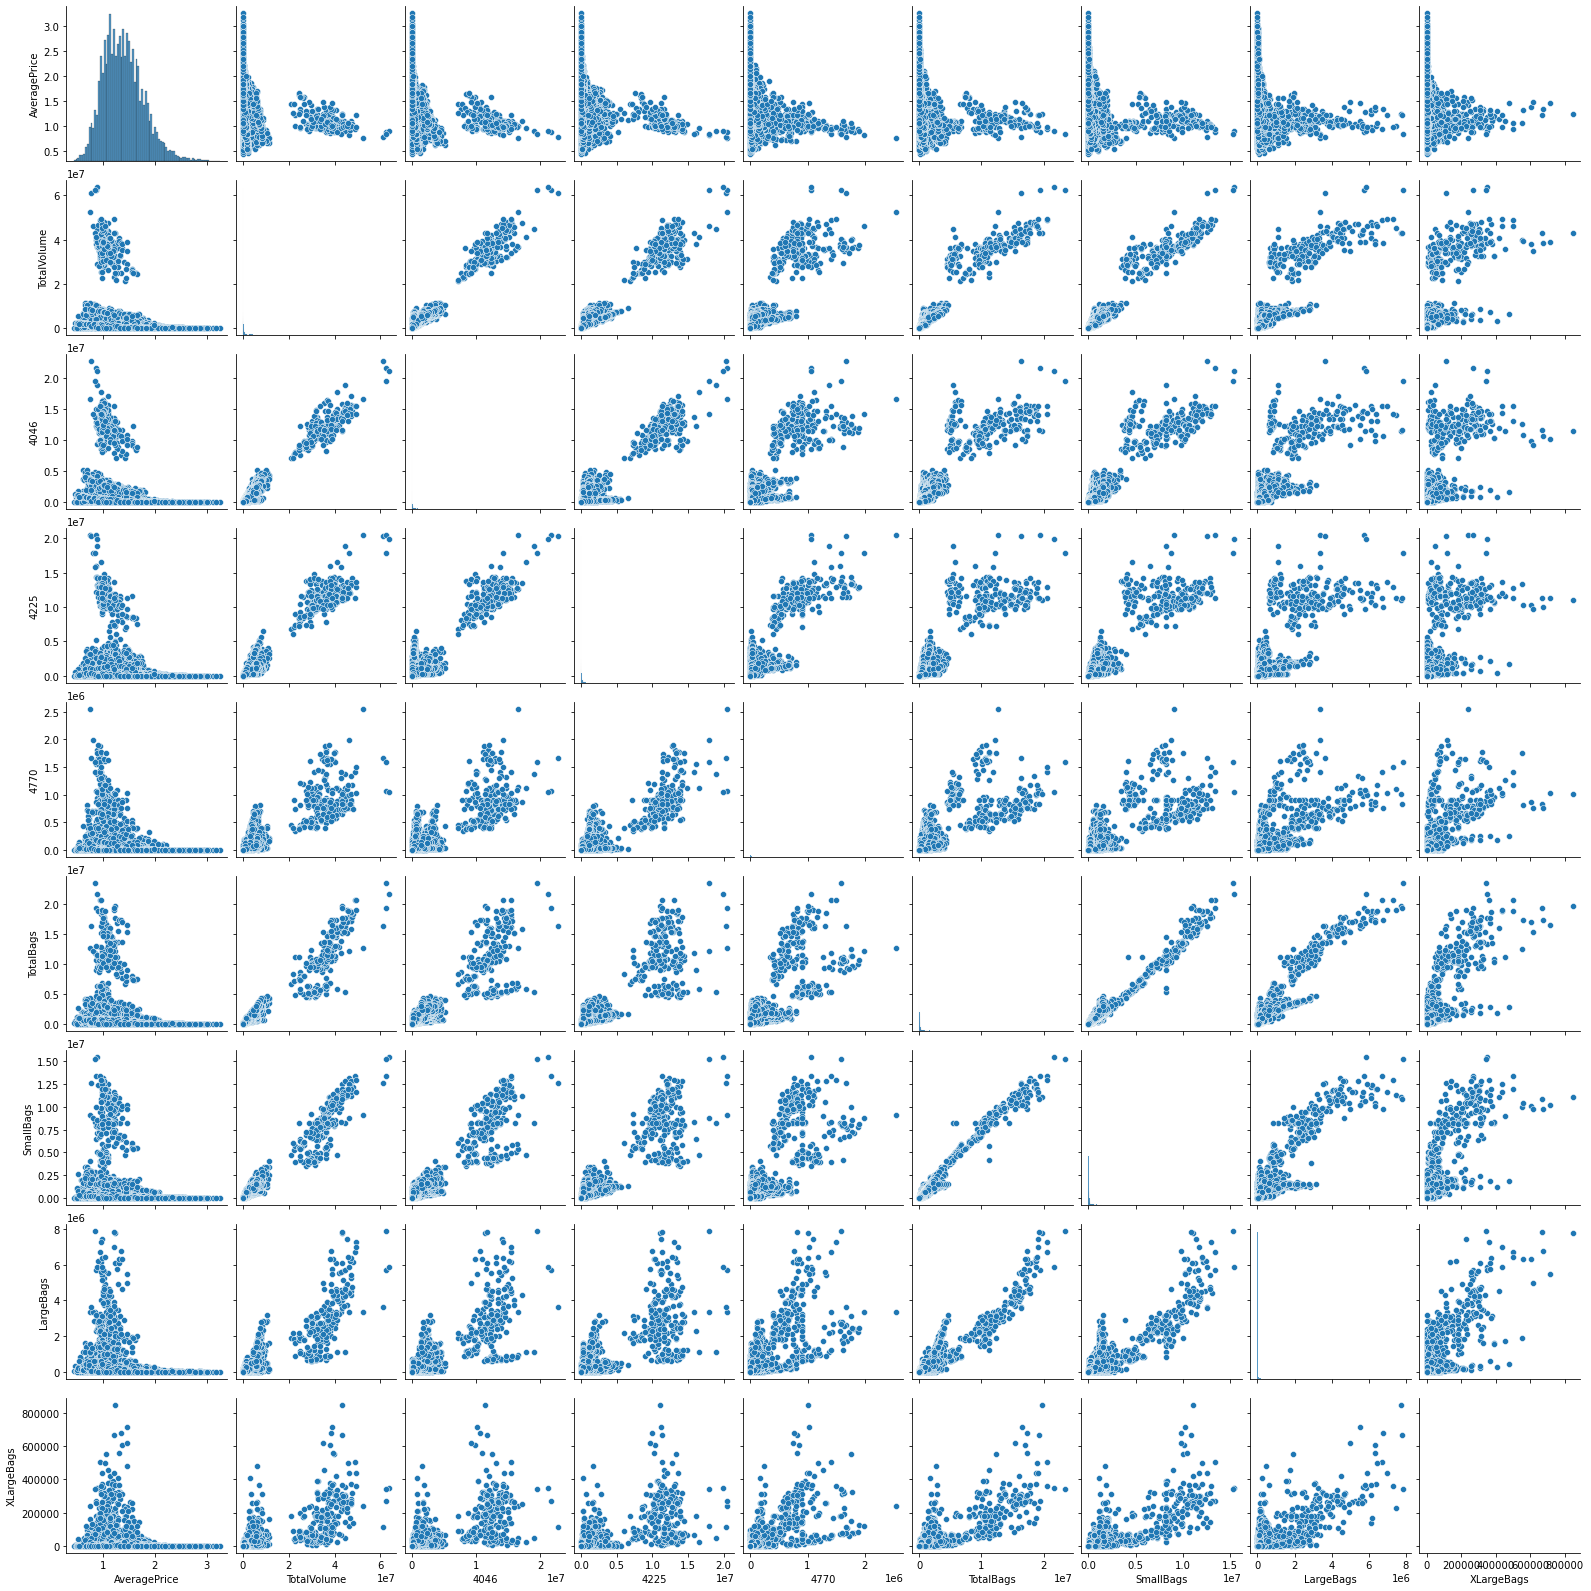

In [16]:
# fields are columns numbered 1 until -3 (type, excluded)
seaborn.pairplot(df[df.columns[1:-3]])

The dataset is not normally distributed. As observed, they are distributed on different scales. Therefore, scaling, instead of normalising, will be used. 

On a side note, With this cured dataset, TotalBags and SmallBags seem to have a linear relationship.  

At this point, the data should be meaningful and and is prepared to perform Machine Learning. 

### Machine Learning

The fields (columns) chosen are:
* "AveragePrice"
* "TotalVolume"
* "TotalBags"
* "SmallBags"
* "LargeBags"
* "XLargeBags"

with "type" as the target.

Reasons:

Assume that the data available in data lake will certainly differ from one to another. If selecting so many fields, the advance-knowledge can be too detailed which can result in aggresive learning. Furthermore, replacing so real data with our data can make the model biased and generate unwanted outcomes. Additionally, fields such as 4046 4225 can vary by code, etc. 

For example, in data lake:

- Entity A has published its average price, total volume, total bags sold, 4770, small - large - xlarge and different type value compared to ours. 
- Entity B has published its average price, total volume, total bags, small - large - xlarge bags, no type. 
- Entity C has published its Total volume, 4225, 4330, 4561, total bags, small - large - xlarge, type, year, different region. 

The joint fields, and most basic fields when generating a report, are average price, total volume, total bags. 

This way, if we want to see how the market is performing based on our knowledge, it is good to focus on the join fields. 

In [18]:
# prepare a Machine learning model with this function
def ml_model(df):
    '''
    Prepare a machine learning model and replacing lexical data with numbers
    '''
    # make a copy of the original df 
    ml_df = df
    
    # replace regions with 0 and 1
    ml_df["type"] = ml_df["type"].replace("conventional", "0")
    ml_df["type"] = ml_df["type"].replace("organic", "1")
    
    # replace region with the code from 0 to 53
    region_zipped_values = list(zip(set(df["region"]), range(len(set(df["region"])))))
    for i in region_zipped_values:
        ml_df["region"] = ml_df["region"].replace(i[0], i[1])

    # features that are interested in 
    features = ["AveragePrice", "TotalVolume", "TotalBags", "SmallBags", "LargeBags", "XLargeBags", "type"]
    
    return df[features], features

ml_df, features = ml_model(df)

Let's import the required ML libraries

Also, it is known that the scale used within the features are different. 

It is best to assert that should the original data or ones that are normalized perform better. 

In [19]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler


In [19]:
# Decision Tree and KNN are put into this function
# Since they have quite the same technique 
# one is depth of tree, one is number of clusters 
def tree_or_knn(df, method, ratio):
    '''
    Check overfitting of the given dataframe
    Input: df - dataframe, depth: depth of the tree
    '''
    # define X, y
    X, y  = df[df.columns[:-1]], df['type']
    
    # personal testing: ratio of train-test set of 70-30 or 80-20 does not change
    # for personal interest, 80-20 is chosen 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ratio, random_state=42)
    
        
    # scale the dataset so that they are in the same range
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # call the "length of tree" or "number of clusters" 
    depth_range = list(range(1, 31))
    
    # intitate variables to store the scores of each depth
    train_scores, test_scores = list(), list()
    
    # loop through each depth
    for i in depth_range:
        # call the appropriate ML model
        if method == "tree":
            clf = DecisionTreeClassifier(max_depth = i)
        else:
            clf = KNeighborsClassifier(n_neighbors=i)
                 
        # fit model with the train data
        clf.fit(X_train, y_train)

        # testing on X_train
        ypred_train = clf.predict(X_train)
        # get the accuracy score
        train_accuracy = accuracy_score(y_train, ypred_train)
        # store the train scores
        train_scores.append(train_accuracy)

        # testing on X_test
        ypred_test = clf.predict(X_test)
        # get the accuracy score
        test_accuracy = accuracy_score(y_test, ypred_test)
        # streo the test scores
        test_scores.append(test_accuracy)
        # print the accuracy
        print(f"Depth: {i} - Accuracy: {test_accuracy}")
    # plot them to observe the performance
    # and to learn how fit the model is

    plt.plot(depth_range, train_scores, '-o', label="train")
    plt.plot(depth_range, test_scores, '-o', label="test")

    if method == "tree":
        plt.xlabel("Depth of Tree")
        plt.title("Decision Tree")
    else:
        plt.xlabel("Number of Clusters")
        plt.title("KNN")
    plt.ylabel("Percentage")
    plt.legend()

    return None

Depth: 1 - Accuracy: 0.9123783031988874
Depth: 2 - Accuracy: 0.9123783031988874
Depth: 3 - Accuracy: 0.9459566858732367
Depth: 4 - Accuracy: 0.951718656864693
Depth: 5 - Accuracy: 0.9521160341744487
Depth: 6 - Accuracy: 0.9614544009537055
Depth: 7 - Accuracy: 0.965030796741506
Depth: 8 - Accuracy: 0.9678124379097953
Depth: 9 - Accuracy: 0.9686071925293066
Depth: 10 - Accuracy: 0.9680111265646731
Depth: 11 - Accuracy: 0.96920325849394
Depth: 12 - Accuracy: 0.9690045698390621
Depth: 13 - Accuracy: 0.9717862110073515
Depth: 14 - Accuracy: 0.9703953904232069
Depth: 15 - Accuracy: 0.9715875223524737
Depth: 16 - Accuracy: 0.9705940790780846
Depth: 17 - Accuracy: 0.9697993244585734
Depth: 18 - Accuracy: 0.9686071925293066
Depth: 19 - Accuracy: 0.968209815219551
Depth: 20 - Accuracy: 0.96920325849394
Depth: 21 - Accuracy: 0.9696006358036956
Depth: 22 - Accuracy: 0.9694019471488178
Depth: 23 - Accuracy: 0.9694019471488178
Depth: 24 - Accuracy: 0.9697993244585734
Depth: 25 - Accuracy: 0.96979932

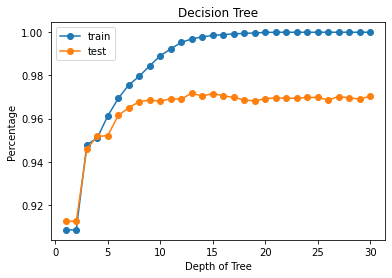

In [20]:
# Examine the performance on Train-Test 80-20
tree_or_knn(ml_df, "tree", 0.2)

Depth: 1 - Accuracy: 0.9101867797059213
Depth: 2 - Accuracy: 0.9101867797059213
Depth: 3 - Accuracy: 0.9454232348655451
Depth: 4 - Accuracy: 0.9503245462975228
Depth: 5 - Accuracy: 0.9537687110875612
Depth: 6 - Accuracy: 0.9602596370380183
Depth: 7 - Accuracy: 0.9660882236057756
Depth: 8 - Accuracy: 0.9680752417538747
Depth: 9 - Accuracy: 0.9697973241488939
Depth: 10 - Accuracy: 0.9682077096304146
Depth: 11 - Accuracy: 0.9691349847661942
Depth: 12 - Accuracy: 0.9703271956550537
Depth: 13 - Accuracy: 0.9712544707908333
Depth: 14 - Accuracy: 0.9700622599019738
Depth: 15 - Accuracy: 0.9690025168896542
Depth: 16 - Accuracy: 0.969532388395814
Depth: 17 - Accuracy: 0.969399920519274
Depth: 18 - Accuracy: 0.9705921314081335
Depth: 19 - Accuracy: 0.969532388395814
Depth: 20 - Accuracy: 0.9704596635315936
Depth: 21 - Accuracy: 0.9703271956550537
Depth: 22 - Accuracy: 0.9697973241488939
Depth: 23 - Accuracy: 0.9687375811365744
Depth: 24 - Accuracy: 0.9708570671612134
Depth: 25 - Accuracy: 0.9703

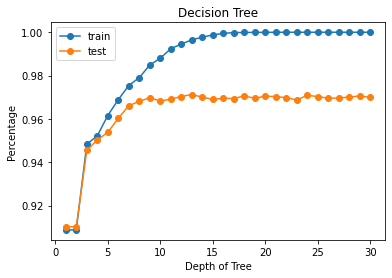

In [21]:
# Examine the performance on Train-Test 70-30
tree_or_knn(ml_df, "tree", 0.3)

For Train-Test ratio:
- 80-20: Depth at 8-9 gives the best generalised prediction with accuracy at around 96.8%
- 70-30: Depth at 8-9 gives the best generalised prediction with accuracy at around 96.8%

Prediction at the ratio of 70-30 seems more stable than the other.

In [22]:
# get the metrics for depth of 8
# get the train-test set for decision tree
# define X, y
X, y  = ml_df[ml_df.columns[:-1]], ml_df['type']

# personal testing: ratio of train-test set of 70-30 or 80-20 does not change
# for personal interest, 80-20 is chosen 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# scale the dataset so that they are in the same range
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

clf = DecisionTreeClassifier(max_depth = 8)
clf.fit(X_train, y_train)

# predict the values
y_pred = clf.predict(X_test)

# calculate the metrics
print("Classification Report:\n", classification_report(y_test,y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test,y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      3756
           1       0.97      0.97      0.97      3793

    accuracy                           0.97      7549
   macro avg       0.97      0.97      0.97      7549
weighted avg       0.97      0.97      0.97      7549

Confusion Matrix:
 [[3628  128]
 [ 114 3679]]


Depth: 1 - Accuracy: 0.9499304589707928
Depth: 2 - Accuracy: 0.9479435724220147
Depth: 3 - Accuracy: 0.9503278362805484
Depth: 4 - Accuracy: 0.9491357043512816
Depth: 5 - Accuracy: 0.9501291476256706
Depth: 6 - Accuracy: 0.9481422610768925
Depth: 7 - Accuracy: 0.9469501291476257
Depth: 8 - Accuracy: 0.9469501291476257
Depth: 9 - Accuracy: 0.9443671766342142
Depth: 10 - Accuracy: 0.9435724220147029
Depth: 11 - Accuracy: 0.9411881581561693
Depth: 12 - Accuracy: 0.9395986489171468
Depth: 13 - Accuracy: 0.9380091396781244
Depth: 14 - Accuracy: 0.93840651698788
Depth: 15 - Accuracy: 0.9372143850586132
Depth: 16 - Accuracy: 0.9350288098549573
Depth: 17 - Accuracy: 0.9364196304391019
Depth: 18 - Accuracy: 0.9336379892708127
Depth: 19 - Accuracy: 0.9320484800317902
Depth: 20 - Accuracy: 0.9302602821378899
Depth: 21 - Accuracy: 0.9302602821378899
Depth: 22 - Accuracy: 0.9314524140671567
Depth: 23 - Accuracy: 0.9316511027220346
Depth: 24 - Accuracy: 0.9286707728988675
Depth: 25 - Accuracy: 0.929

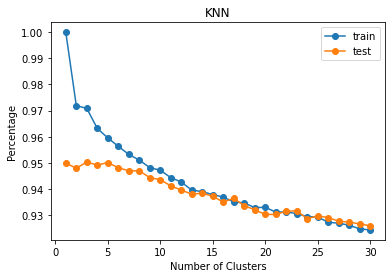

In [23]:
# Examine the performance on Train-Test 80-20
tree_or_knn(ml_df, "knn", 0.2)

For kNN: The model does not perform well and seems overfitted. Therefore, it is unnecessary to test with ratio of 70-30

There is also Support Vector Machine (SVM). For this technique, we will use cross validation to cross check its performance:

In [24]:
from sklearn import svm
from sklearn.model_selection import cross_val_score, cross_val_predict


 # define X, y
X, y  = ml_df[ml_df.columns[:-1]], ml_df['type']

def svm_model(X, y, ratio):
    '''
    Testing the accuracy of SVM model
    '''
    # scale the dataset so that they are in the same range
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    
    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ratio)

    clf = svm.SVC()
    clf.fit(X_train, y_train)

    degrees = list(range(3, 10))
    for d in degrees:
        # get the accuracy 
        score = cross_val_score(clf, X_test, y_test, scoring="accuracy", cv=d).mean()
        print(f"Degrees: {d} - Accuracy: {score}")
    return None   
# Examine the performance with Train-Test 80-20
svm_model(X, y, 0.2)

Degrees: 3 - Accuracy: 0.845418476956576
Degrees: 4 - Accuracy: 0.8452228217564852
Degrees: 5 - Accuracy: 0.8470071329717822
Degrees: 6 - Accuracy: 0.8470088363329835
Degrees: 7 - Accuracy: 0.8476058017087224
Degrees: 8 - Accuracy: 0.846810886516769
Degrees: 9 - Accuracy: 0.8482050572166852


In [25]:
# Examine the performance with Train-Test 80-20
svm_model(X, y, 0.3)

Degrees: 3 - Accuracy: 0.854814816218448
Degrees: 4 - Accuracy: 0.8583916044658816
Degrees: 5 - Accuracy: 0.8594513273559526
Degrees: 6 - Accuracy: 0.8603776181919432
Degrees: 7 - Accuracy: 0.8614379227853534
Degrees: 8 - Accuracy: 0.8614363530564193
Degrees: 9 - Accuracy: 0.8621001691283678


Around 85% is a lower percentage compared to Decision Tree. Therefore, this will be put aside.

However, SVM is known for multiclass classification, let's see whether SVM can tell where the location can be

In [26]:
# define X, y 
X, y = ml_df[ml_df.columns], df['region']
# examine the performance with Train-Test 70-30
svm_model(X, y, 0.2)

Degrees: 3 - Accuracy: 0.06854782825622974
Degrees: 4 - Accuracy: 0.07192569619565835
Degrees: 5 - Accuracy: 0.07411143861754993
Degrees: 6 - Accuracy: 0.07470963557593567
Degrees: 7 - Accuracy: 0.07490562288893306
Degrees: 8 - Accuracy: 0.07490694475988594
Degrees: 9 - Accuracy: 0.0745105346849533


In [27]:
# examine the performance with Train-Test 80-20
svm_model(X, y, 0.3)

Degrees: 3 - Accuracy: 0.07153265584170725
Degrees: 4 - Accuracy: 0.0725931720603954
Degrees: 5 - Accuracy: 0.0774941520852808
Degrees: 6 - Accuracy: 0.07550659101843515
Degrees: 7 - Accuracy: 0.07776032671533041
Degrees: 8 - Accuracy: 0.07935043788306342
Degrees: 9 - Accuracy: 0.08199849614506795


Around 37% and 33% for Train-Test of 70-30 and 80-20 respectively are not good enough to make predictions. 

This hypothesis is rejected.


## Conclusion

- Decision Tree performs the best with accuracy (f1-score) = 96%.
- Depending on the prefernce of data normalisation, depth 7 can be the safest point. 
- Region forecast cannot be done.
- Linear relationship between "TotalBags" and "SmallBags" exists only in cured and original data but normalized. 

In [16]:
df1 = df

In [17]:
import torch
import torchvision
from torchvision import transforms, datasets

In [ ]:
# define X, y
X, y  = ml_df[ml_df.columns[:-1]], ml_df['type']

# personal testing: ratio of train-test set of 70-30 or 80-20 does not change
# for personal interest, 80-20 is chosen 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ratio, random_state=42)


# scale the dataset so that they are in the same range
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
trainset = torch.utils.data.DataLoader(X_train, batch_size=10, shuffle=True)
testset = torch.utils.data.DataLoader(y_test, batch_size=10, shuffle=True)